In [ ]:
#installing all the dependencies
!pip install openai
!pip install scikit-learn
!pip install umap-learn
!pip install plotly
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=f5a0021b0e3786d0991a14ada2080dc6547255f31d6592b25e7f18917f9607a3
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import openai
from openai import OpenAI
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap
from umap import UMAP
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Loading Data**#

In [ ]:
from google.colab import auth
import pandas as pd
import gspread
from google.auth import default

# Accessing Google Drive
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Reading from spreadsheet with manually labeled data
worksheet = gc.open('Data Labelling').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame(rows[1:], columns=rows[0])

# Extracting resume text from the data frame
text_column = df['Text']
gender_column = df['Gender']
print(df.head)

<bound method NDFrame.head of                  Name                                               Text  \
0    Om Prakash Jagri  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/om...   
1     Saurab Shrestha  Contact\nwww.linkedin.com/in/saurab-shrestha-5...   
2         Sumit Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/er...   
3     Rahul Chaudhary  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ra...   
4     Dhirendra Thapa  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/dh...   
..                ...                                                ...   
895   Anushuya Baidya  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/an...   
896     Sanskar Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sa...   
897     Chase Millard  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ch...   
898     Durga Bahadur  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/du...   
899    Shirisha Regmi  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sh...   

     Gender  
0      Male  
1      Male  
2      Male  
3

##Exploratory Data Analysis##

In [ ]:
print(df['Gender'].value_counts())

Male      772
Female    128
Name: Gender, dtype: int64


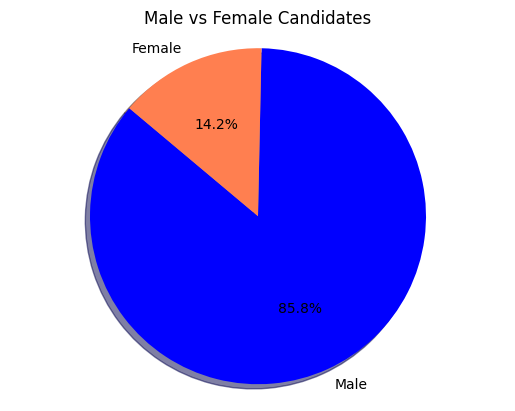

In [ ]:
#comparing the number of male vs female candidates
candidates = 'Male', 'Female'
number = [772, 128]
colors = ['blue', 'coral']

# Plot
plt.pie(number, labels=candidates, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Male vs Female Candidates')
plt.show()

In [ ]:
#comparing the length of male vs female resume texts

df['text_length'] = df['Text'].apply(len)
avg_len = df.groupby('Gender')['text_length'].mean()

print(avg_len)

Gender
Female    1922.539062
Male      2291.485751
Name: text_length, dtype: float64


#**Text Processing**#

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

def remove_stop_words(sentence):
  words = sentence.split()
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def text_preprocessing(str):
   # normalization
   no_newlines_string = str.replace('\\n', ' ')
   no_unicode_string = re.sub(r'\\u[\da-fA-F]{4}', '', no_newlines_string)
   no_caps_string = no_unicode_string.lower()
   no_number_string = re.sub(r'\d+','', no_caps_string)
   no_punc_string = re.sub(r'[^\w\s]','', no_number_string)
   no_wspace_string = no_punc_string.strip()
   no_stop_words_string = remove_stop_words(no_wspace_string)
   no_tags_string = re.sub(r'Page \d+ of \d+', '', no_stop_words_string)
   no_linkedin_string = re.sub(r'\bwwwlinkedincom\S*\b', '', no_tags_string)

  #  #lemmatization
   lemmatizer = WordNetLemmatizer()
   lemmatized_string = lemmatizer.lemmatize(no_linkedin_string)

   return lemmatized_string


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
preprocessed_resume_text = df['Text'].apply(text_preprocessing)
df['preprocessed_text'] = preprocessed_resume_text

print(preprocessed_resume_text[0])

contact  linkedin top skills php mysql javascript certifications php js om prakash jagri full stack developer php laravel vue js kathmandu bgmat nepal summary experienced developer demonstrated history working information technology services industry skilled laravel php cascading style sheets css javascript vue js mysql strong engineering professional bsccsitbachelors science computer science information technology focused computer science tribhuvan university institute science tchnology experience searchable design llc software developer june present year months nepal full stack developer laravel vue js benekiva technical documentation september present year months united states bidhee years months laravel developer march may years months baneswar kathamandu internship september february months kathamandu nepal web development phpjs laravel framework education page siddhanath science campus mahendranagar bsccsitbachelors science computer science information technologycomputer science 

#**Embeddings WITH Gender**#

In [ ]:
#import the key
#we must set open api key as an environment variable
var_name = 'OPENAI_API_KEY'
os.unsetenv(var_name)

os.environ[var_name] = ""
API_KEY = os.getenv("OPENAI_API_KEY")

openai.api_key = API_KEY

client = OpenAI()

#this function generate the embedding for any text using the latest embedding model
#1k tokens priced at $0.00002
def generate_embeddings(text):
  response = client.embeddings.create(input = [text],
                                      model="text-embedding-3-small")

  return response.data[0].embedding


In [ ]:
#************PLEASE DONT RUN THIS CELL AGAIN*************************
#generating embeddings for the resume texts + gender

'''
df['combined_textgender'] = df['preprocessed_text'] + " " + df['Gender'].astype(str)
df['embedding'] = df['combined_textgender'].apply(generate_embeddings)

#saving the embeddings in a csv file for cost efficiency
path = '/content/drive/MyDrive/gpt_resume_embeddings.csv'
df.to_csv(path, index=False)'''

In [ ]:
#generate embeddings for the job description
# Job embedding pipeline

file_path = '/content/drive/MyDrive/job_description (1).txt'

# Read the job description
with open(file_path, 'r') as file:
    job_text = file.read()

# Preprocess job description text
preprocessed_job_text = text_preprocessing(job_text)
print(preprocessed_job_text)

#embedding
job_embedding = generate_embeddings(preprocessed_job_text)

print(job_embedding)

description looking net full stack developer role experience front end scripting javascript reactjsangular broker dealer regulatory reporting technology function set replace legacy systems processes efficient technology stack endtoend automation daily report generation process data sourcing approved data source ads enabling firm calculate accurate amounts report activity sec finra currently working modernization effort upgrade ui framework react js technology improve overall user experience looking motivated net full stack developer enhance ui performance improve user productivity enabling application quicker data rendering types user queries responsibilities include develop design document test ui solutions automating regulatory report generation process broker dealer business perform necessary research support enhance new tasks related net unix pega axiom technologies collaborate developers team build highquality reusable code used future understand current application including serv

In [ ]:
#reading the csv file with embeddings
pd.set_option('display.max_rows', 10)

path = '/content/drive/MyDrive/gpt_resume_embeddings.csv'
df_embeddings = pd.read_csv(path)
print(df_embeddings.head)

<bound method NDFrame.head of                  Name                                               Text  \
0    Om Prakash Jagri  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/om...   
1     Saurab Shrestha  Contact\nwww.linkedin.com/in/saurab-shrestha-5...   
2         Sumit Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/er...   
3     Rahul Chaudhary  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ra...   
4     Dhirendra Thapa  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/dh...   
..                ...                                                ...   
895   Anushuya Baidya  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/an...   
896     Sanskar Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sa...   
897     Chase Millard  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ch...   
898     Durga Bahadur  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/du...   
899    Shirisha Regmi  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sh...   

     Gender  text_length                                 

##**Visualizing Job Embeddings**##

In [ ]:
#using cluster embedding such that similar resumes can be shown together

df_embeddings['embedding'] = df_embeddings['embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
#we only want to visualize 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_embeddings["embedding"].tolist())

#reduce the dimensions using UMAP - reduce dimensions to 2D to be able to visualize it
red = UMAP()
embeddings_2d = red.fit_transform(df_embeddings["embedding"].tolist())

#visualize
fig = px.scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], color=kmeans.labels_)
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##**Ranking Resumes**##

In [ ]:
# Calculate cosine similarity between resume embeddings and job description embedding
#df_embeddings['embedding'] = df_embeddings['embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
embeddings = df_embeddings['embedding']

def get_cosine_similarity(resume_embedding):
  resume = resume_embedding.reshape(1, -1)
  job_description =  np.array(job_embedding).reshape(1, -1)
  similarity = cosine_similarity(resume, job_description)
  sim_list = similarity.tolist()
  return sim_list[0][0]

similarities = []
index = 0
for embedding in embeddings:
    similarity = get_cosine_similarity(embedding)
    similarities.append([similarity, index])
    index += 1

print(similarities)


[[0.5933038254553022, 0], [0.5673894411206631, 1], [0.5438952404090367, 2], [0.41786685583075767, 3], [0.5664169915135422, 4], [0.4923225196696767, 5], [0.5877444046183558, 6], [0.5948282281046289, 7], [0.5800576109130863, 8], [0.5548130032515671, 9], [0.5831500201515106, 10], [0.5220474112936276, 11], [0.5728993333701304, 12], [0.5982716425808692, 13], [0.5570929125779385, 14], [0.572054041597284, 15], [0.5791536609329833, 16], [0.5967762968337443, 17], [0.5180668150844151, 18], [0.5983446945055484, 19], [0.5515467073373357, 20], [0.6323601743255003, 21], [0.5269651828489672, 22], [0.5295264548359808, 23], [0.5704068152265467, 24], [0.6841937176404874, 25], [0.520012776017803, 26], [0.5917641915899994, 27], [0.6272054337036842, 28], [0.5474192153486539, 29], [0.5609189191015693, 30], [0.4911244753358217, 31], [0.6259588555154214, 32], [0.6329507619355357, 33], [0.5547385910258158, 34], [0.5366200389386608, 35], [0.5481897527427212, 36], [0.4466936061568713, 37], [0.5697303319591094, 3

In [ ]:
# Get top 20 resumes
sorted_list = sorted(similarities, key=lambda x: x[0], reverse=True)
top_20_resumes = sorted_list[:20]
print(top_20_resumes)

[[0.7480318560125123, 537], [0.7399354029741283, 380], [0.7250078699379423, 454], [0.7227022628336256, 663], [0.7200520166447795, 185], [0.7142581398882517, 211], [0.7039846693216643, 621], [0.7013339218386534, 597], [0.6972582301058512, 561], [0.6958913297101286, 548], [0.6954267156325216, 446], [0.6952595518569568, 106], [0.6951896554584815, 464], [0.695010245878547, 313], [0.6950020359703373, 247], [0.6946721053662965, 600], [0.6938303867264897, 181], [0.6929531693604551, 897], [0.6920896955451346, 690], [0.6918537062246801, 862]]


In [ ]:
gender_column = df_embeddings['Gender']

def display_gender(index):
  print(gender_column[index])

for resume in top_20_resumes:
  display_gender(resume[1])
  # print(preprocessed_resume_text[resume[1]])

Male
Male
Male
Female
Male
Male
Male
Male
Male
Male
Male
Female
Male
Male
Male
Male
Male
Male
Male
Male


##**Visualizing the Bias**##

In [ ]:
def word_frequency(words_list):
    frequency_dict = {}

    for word in words_list:
        frequency_dict[word] = frequency_dict.get(word, 0) + 1

    word_freq_list = [[word, freq] for word, freq in frequency_dict.items()]

    sorted_word_freq_list = sorted(word_freq_list, key=lambda x: x[1], reverse=True)

    return sorted_word_freq_list

In [ ]:
def display_word_cloud(text):
  wordcloud = WordCloud(width = 2500, height = 2500,
                background_color ='white',
                stopwords = ['u00e7', 'u00a0','u00b7','u2022','u00e3o','nwww'],
                min_font_size = 10).generate(text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

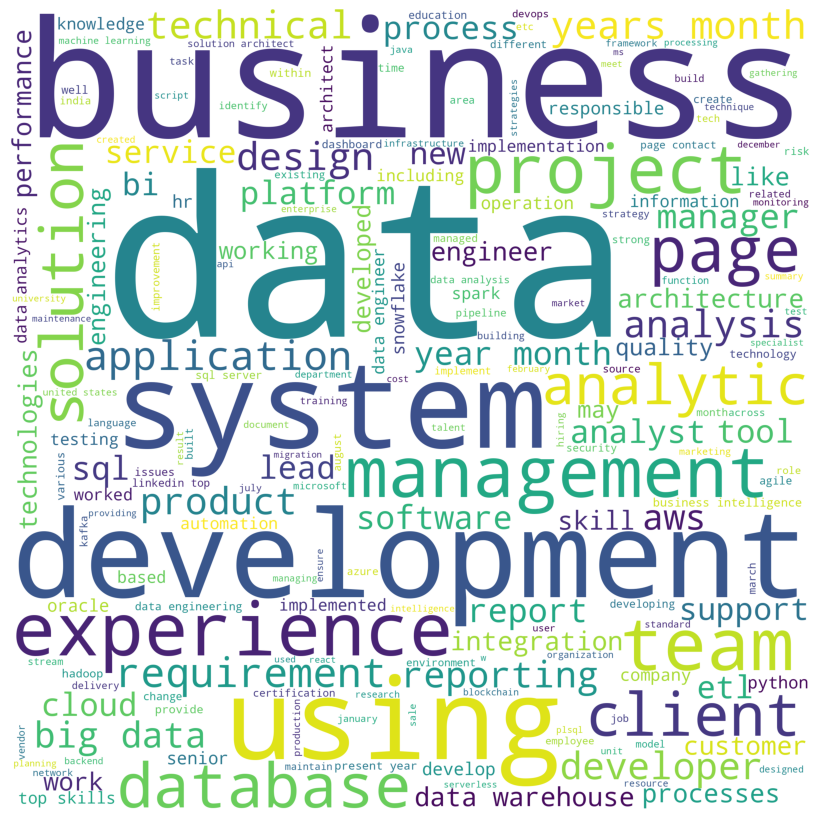

In [ ]:
#visualizing the word cloud for top 20 resumes
text_column = df_embeddings['preprocessed_text']
text_lst = []

for resume in top_20_resumes:
  index = resume[1]
  text_lst.append(text_column[index])

full_text = " ".join(text_lst)
display_word_cloud(full_text)


In [ ]:
#the most frequent verbs used in top 20 resumes
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob

text_from_top_20_resumes = ''
for sim, index in top_20_resumes:
  text_from_top_20_resumes += preprocessed_resume_text[index]
blob = TextBlob(text_from_top_20_resumes)
verbs = [word for (word, tag) in blob.tags if tag.startswith('VB')]

print("Verbs by frequency", word_frequency(verbs))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Verbs by frequency [['using', 88], ['working', 43], ['reporting', 32], ['worked', 26], ['developing', 24], ['developed', 23], ['aws', 21], ['based', 20], ['including', 20], ['testing', 20], ['processes', 20], ['develop', 20], ['implemented', 17], ['designing', 16], ['existing', 16], ['learning', 16], ['managed', 15], ['built', 15], ['certified', 14], ['provide', 14], ['streaming', 13], ['sql', 13], ['designed', 12], ['created', 12], ['computing', 12], ['snowflake', 12], ['managing', 12], ['architect', 11], ['scripting', 11], ['providing', 11], ['ensure', 11], ['identify', 11], ['implementing', 10], ['setting', 10], ['used', 10], ['handling', 10], ['tuning', 10], ['hiring', 10], ['maintaining', 10], ['leading', 9], ['create', 9], ['oracle', 9], ['ensuring', 9], ['engineer', 9], ['scheduling', 9], ['programming', 8], ['building', 8], ['page', 8], ['integrated', 8], ['databases', 8], ['lead', 8], ['planning', 8], ['driving', 8], ['kathmandu', 8], ['atlanta', 8], ['experienced', 7], ['help

In [ ]:
#extracting the most common words from the top 20 resumes
#for the purpose of this research we are selecting words manually so that we can find common verbs - not nouns.

#using, working reporting, worked, developing, developed, based, including, testing, processes


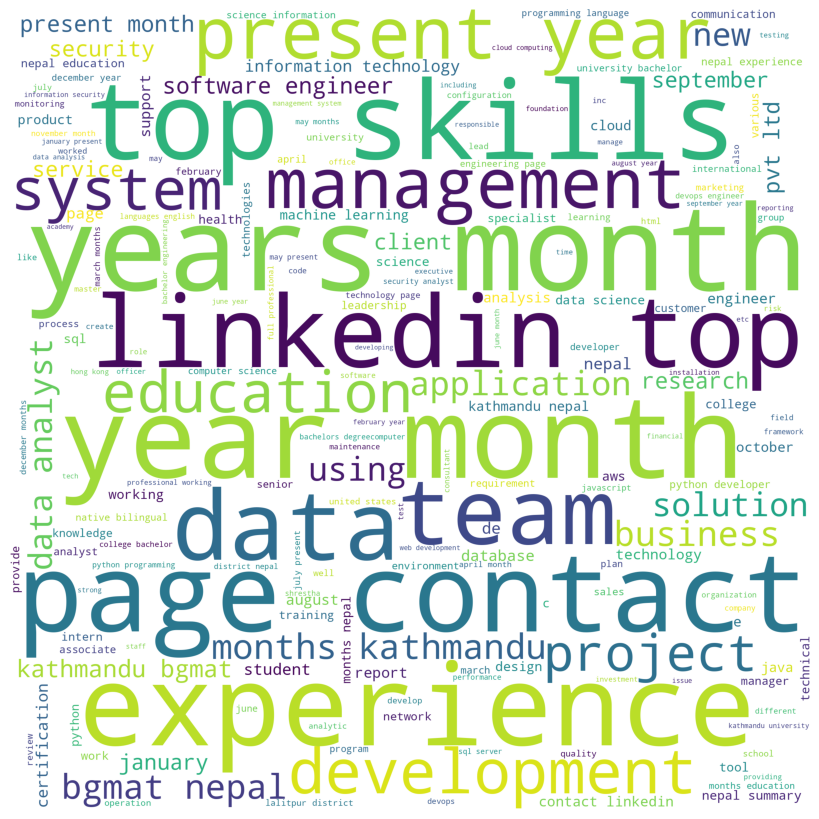

In [ ]:
#visualizing the word cloud for all female candidates

#seperate all the male and female texts first
female_txts = df_embeddings[df_embeddings['Gender'] == 'Female']['preprocessed_text'].tolist()
full_text_female = " ".join(female_txts)
display_word_cloud(full_text_female)

In [ ]:
female_blob = TextBlob(full_text_female)
female_verbs = [word for (word, tag) in female_blob.tags if tag.startswith('VB')]

print("Verbs by frequency", word_frequency(female_verbs))

Verbs by frequency [['kathmandu', 97], ['learning', 79], ['working', 75], ['using', 56], ['engineer', 36], ['computing', 33], ['programming', 32], ['certified', 27], ['testing', 27], ['page', 25], ['worked', 22], ['languages', 22], ['aws', 19], ['degree', 19], ['experienced', 19], ['providing', 19], ['based', 18], ['skilled', 18], ['including', 18], ['develop', 18], ['monitoring', 18], ['present', 17], ['provide', 17], ['started', 17], ['september', 17], ['degreecomputer', 16], ['python', 16], ['pvt', 15], ['demonstrated', 15], ['focused', 15], ['advanced', 15], ['lalitpur', 14], ['developing', 14], ['cloud', 13], ['conducted', 13], ['experience', 13], ['conducting', 13], ['managing', 13], ['creating', 13], ['solving', 12], ['identify', 12], ['managed', 12], ['regarding', 12], ['improve', 11], ['performed', 11], ['limited', 11], ['work', 11], ['make', 11], ['leading', 11], ['reporting', 11], ['applied', 10], ['developed', 10], ['associate', 10], ['include', 10], ['making', 10], ['data'

In [ ]:
# learning, working, using, engineer, computing, programming, certified, testing, worked, experienced ...

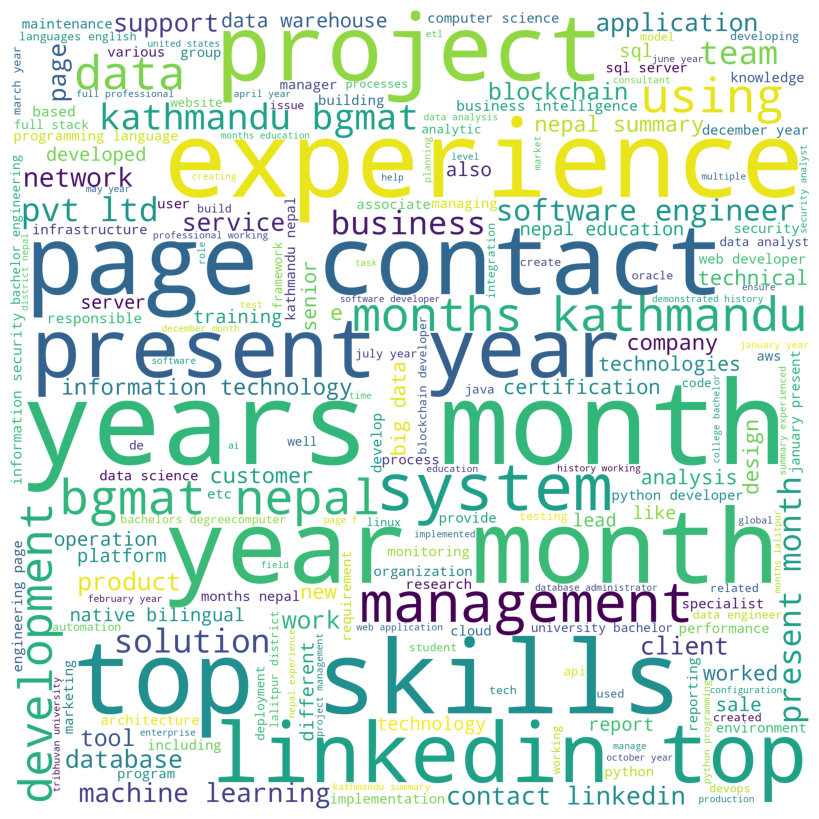

In [ ]:
#visualizing the word cloud for all male candidates
male_txts = df_embeddings[df_embeddings['Gender'] == 'Male']['preprocessed_text'].tolist()
full_text_male = " ".join(male_txts)
display_word_cloud(full_text_male)

In [ ]:
male_blob = TextBlob(full_text_male)
male_verbs = [word for (word, tag) in male_blob.tags if tag.startswith('VB')]

print("Verbs by frequency", word_frequency(male_verbs))

Verbs by frequency [['using', 629], ['kathmandu', 612], ['working', 563], ['learning', 447], ['worked', 252], ['engineer', 248], ['programming', 242], ['certified', 221], ['testing', 178], ['developing', 172], ['developed', 164], ['based', 163], ['pvt', 143], ['page', 134], ['experienced', 133], ['managing', 132], ['including', 132], ['languages', 131], ['develop', 129], ['degreecomputer', 121], ['aws', 120], ['designing', 118], ['used', 115], ['python', 113], ['skilled', 112], ['frontend', 111], ['creating', 107], ['computing', 107], ['created', 107], ['september', 102], ['demonstrated', 99], ['focused', 98], ['blockchain', 98], ['provide', 97], ['lalitpur', 96], ['ensure', 91], ['implemented', 90], ['managed', 86], ['degree', 81], ['reporting', 81], ['planning', 80], ['providing', 79], ['present', 79], ['maintaining', 79], ['implementing', 77], ['building', 77], ['existing', 77], ['training', 75], ['monitoring', 74], ['web', 74], ['built', 73], ['troubleshooting', 72], ['education', 

In [ ]:
# using, working, learning, worked, engineer, programming, certified, testing, developing, developed...

#**Debiasing Techniques**#

##**Insertion of Common Verbs in Female Resumes**##

---



In [ ]:
# top common verbs in the job description
print(preprocessed_job_text)

job_blob = TextBlob(preprocessed_job_text)
job_verbs = [word for (word, tag) in job_blob.tags if tag.startswith('VB')]

print("Verbs by frequency", word_frequency(job_verbs))

description looking net full stack developer role experience front end scripting javascript reactjsangular broker dealer regulatory reporting technology function set replace legacy systems processes efficient technology stack endtoend automation daily report generation process data sourcing approved data source ads enabling firm calculate accurate amounts report activity sec finra currently working modernization effort upgrade ui framework react js technology improve overall user experience looking motivated net full stack developer enhance ui performance improve user productivity enabling application quicker data rendering types user queries responsibilities include develop design document test ui solutions automating regulatory report generation process broker dealer business perform necessary research support enhance new tasks related net unix pega axiom technologies collaborate developers team build highquality reusable code used future understand current application including serv

In [ ]:
#adding the top 10 most common verbs in top 20 ranked resumes to female resumes

# [using, working reporting, worked, developing, developed, based, including, testing, processes]

In [ ]:
words_to_inject = [ 'using', 'reporting', 'working', 'worked', 'developing', 'developed', 'based', 'including', 'testing', 'processes']
text_inject = " ".join(words_to_inject)

df_embeddings['injected_text'] = df_embeddings.apply(lambda x: x['preprocessed_text'] + text_inject if x["Gender"]=='Female' else x['preprocessed_text'],axis=1)
print(df_embeddings.head)

<bound method NDFrame.head of                  Name                                               Text  \
0    Om Prakash Jagri  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/om...   
1     Saurab Shrestha  Contact\nwww.linkedin.com/in/saurab-shrestha-5...   
2         Sumit Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/er...   
3     Rahul Chaudhary  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ra...   
4     Dhirendra Thapa  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/dh...   
..                ...                                                ...   
895   Anushuya Baidya  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/an...   
896     Sanskar Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sa...   
897     Chase Millard  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ch...   
898     Durga Bahadur  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/du...   
899    Shirisha Regmi  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sh...   

     Gender  text_length                                 

In [ ]:
#checking to see if verbs have been injected correctly
df_embeddings['injected_text'][45]

'contact  sharmabba linkedin top skills data analysis corporate law human resources hr languages nepali native bilingual english professional working korean elementary abhigya sharma data analyst cloudfactory lalitpur district nepal summary ordinary undergrad student currently pursuing law dont much working experience well hit want know rights ill look critically dont happen know happy surfing education kathmandu university ku bachelors degreelaw pageusing reporting working worked developing developed based including testing processes'

###Generate Injected Text Embeddings###

In [ ]:
'''
df_embeddings['injected_combined_textgender'] = df_embeddings['injected_text'] + " " + df_embeddings['Gender'].astype(str)
df_embeddings['injected_embedding'] = df_embeddings['injected_combined_textgender'].apply(generate_embeddings)

#saving the embeddings in a csv file for cost efficiency
path = '/content/drive/MyDrive/injected_embeddings.csv'
df_embeddings.to_csv(path, index=False)'''

In [ ]:
#reading the csv file with word injectedembeddings
path = '/content/drive/MyDrive/injected_embeddings.csv'
df_injected_embeddings = pd.read_csv(path)
print(df_injected_embeddings.head)

<bound method NDFrame.head of                  Name                                               Text  \
0    Om Prakash Jagri  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/om...   
1     Saurab Shrestha  Contact\nwww.linkedin.com/in/saurab-shrestha-5...   
2         Sumit Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/er...   
3     Rahul Chaudhary  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ra...   
4     Dhirendra Thapa  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/dh...   
..                ...                                                ...   
895   Anushuya Baidya  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/an...   
896     Sanskar Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sa...   
897     Chase Millard  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ch...   
898     Durga Bahadur  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/du...   
899    Shirisha Regmi  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sh...   

     Gender  text_length                                 

In [ ]:
df_injected_embeddings['injected_embedding'] = df_injected_embeddings ['injected_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))

In [ ]:
# Calculate cosine similarity between resume embeddings and job description embedding
embeddings = df_injected_embeddings['injected_embedding']

def get_cosine_similarity(resume_embedding):
  resume = resume_embedding.reshape(1, -1)
  job_description = np.array(job_embedding).reshape(1, -1)
  similarity = cosine_similarity(resume, job_description)
  sim_list = similarity.tolist()
  return sim_list[0][0]

similarities = []
index = 0
for embedding in embeddings:
    similarity = get_cosine_similarity(embedding)
    similarities.append([similarity, index])
    index += 1

print(similarities)

[[0.5933038254553022, 0], [0.5673468550019221, 1], [0.5438059981746155, 2], [0.41786685583075767, 3], [0.5664169915135422, 4], [0.4923225196696767, 5], [0.5877444046183558, 6], [0.5948282281046289, 7], [0.5799339481610957, 8], [0.5548861021758908, 9], [0.5829293663109202, 10], [0.5220474112936276, 11], [0.5728993333701304, 12], [0.5983404488640025, 13], [0.595765687571662, 14], [0.572054041597284, 15], [0.5795133507168939, 16], [0.5967762968337443, 17], [0.5180668150844151, 18], [0.5984688400216736, 19], [0.5852832265393791, 20], [0.6324116276695106, 21], [0.526902444647576, 22], [0.5295264548359808, 23], [0.5704068152265467, 24], [0.6841937176404874, 25], [0.520012776017803, 26], [0.5917892673163089, 27], [0.6272054337036842, 28], [0.5474520155909097, 29], [0.5607542425848768, 30], [0.49116389697973295, 31], [0.6259588555154214, 32], [0.6329507619355357, 33], [0.5547385910258158, 34], [0.5366200389386608, 35], [0.5481924756847532, 36], [0.4466936061568713, 37], [0.5696753241112906, 38

In [ ]:
# Get top 20 resumes
sorted_list = sorted(similarities, key=lambda x: x[0], reverse=True)
top_20_resumes = sorted_list[:20]
print(top_20_resumes)

[[0.7482197156245638, 537], [0.7399842137823994, 380], [0.7327299880784072, 663], [0.7249133982955953, 454], [0.7200520166447795, 185], [0.7142581398882517, 211], [0.7079776228069042, 106], [0.7039626593921406, 621], [0.7014316702607517, 677], [0.7013339218386534, 597], [0.6978892217138148, 577], [0.6972582301058512, 561], [0.6958913297101286, 548], [0.6954267156325216, 446], [0.6951896554584815, 464], [0.695010245878547, 247], [0.6949914976477112, 313], [0.6946721053662965, 600], [0.6938303867264897, 181], [0.6929531693604551, 897]]


In [ ]:
gender_column = df_injected_embeddings['Gender']

def display_gender(index):
  print(gender_column[index])

for resume in top_20_resumes:
  display_gender(resume[1])
  # print(preprocessed_resume_text[resume[1]])

Male
Male
Female
Male
Male
Male
Female
Male
Female
Male
Female
Male
Male
Male
Male
Male
Male
Male
Male
Male


##**Removal of Gender Column**##

In [ ]:
'''
df_injected_embeddings['embedding_wout_gender'] = df_injected_embeddings['injected_text'].apply(generate_embeddings)

#saving the embeddings in a csv file for cost efficiency
path = '/content/drive/MyDrive/embeddings_wout_gender.csv'
df_injected_embeddings.to_csv(path, index=False)'''

In [ ]:
path = '/content/drive/MyDrive/embeddings_wout_gender.csv'
df_wout_gender = pd.read_csv(path)
print(df_wout_gender.head)

<bound method NDFrame.head of                  Name                                               Text  \
0    Om Prakash Jagri  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/om...   
1     Saurab Shrestha  Contact\nwww.linkedin.com/in/saurab-shrestha-5...   
2         Sumit Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/er...   
3     Rahul Chaudhary  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ra...   
4     Dhirendra Thapa  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/dh...   
..                ...                                                ...   
895   Anushuya Baidya  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/an...   
896     Sanskar Singh  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sa...   
897     Chase Millard  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/ch...   
898     Durga Bahadur  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/du...   
899    Shirisha Regmi  \u00a0 \u00a0\nContact\nwww.linkedin.com/in/sh...   

     Gender  text_length                                 

In [ ]:
df_wout_gender['embedding_wout_gender'] = df_wout_gender['embedding_wout_gender'].apply(lambda x: np.array(ast.literal_eval(x)))

In [ ]:
# Calculate cosine similarity between resume embeddings and job description embedding
embeddings = df_wout_gender['embedding_wout_gender']


similarities = []
index = 0
for embedding in embeddings:
    similarity = get_cosine_similarity(embedding)
    similarities.append([similarity, index])
    index += 1

print(similarities)

[[0.6098057994223304, 0], [0.5787304952660143, 1], [0.5573790814698036, 2], [0.43105141197140623, 3], [0.5755409916729302, 4], [0.4954128810483408, 5], [0.6016759779234312, 6], [0.6095267865292899, 7], [0.6031197719038163, 8], [0.568890074230066, 9], [0.5971598532377932, 10], [0.5196418725878378, 11], [0.5886253946192024, 12], [0.6029367996366024, 13], [0.6040823694517357, 14], [0.5779996430386017, 15], [0.5924135116746962, 16], [0.6131578624302094, 17], [0.5254120013313692, 18], [0.6113845658114718, 19], [0.5979650457692829, 20], [0.6516343523262786, 21], [0.5388552067939743, 22], [0.5361587866344801, 23], [0.5866772898690454, 24], [0.6969854710761435, 25], [0.5295206834236155, 26], [0.6042015298114985, 27], [0.6363456174933304, 28], [0.5576592742630881, 29], [0.5770322256634735, 30], [0.4964046162534703, 31], [0.6448887306662642, 32], [0.6495886621664602, 33], [0.5607956055072898, 34], [0.542107506038202, 35], [0.5665547177213327, 36], [0.4526333658702153, 37], [0.573445963655199, 38

In [ ]:
# Get top 20 resumes
sorted_list = sorted(similarities, key=lambda x: x[0], reverse=True)
top_20_resumes = sorted_list[:20]
print(top_20_resumes)

[[0.7555681177267424, 537], [0.7424974353753938, 380], [0.7423888172750006, 663], [0.7294311320880855, 454], [0.7286052640317267, 185], [0.722552192066527, 106], [0.7205512828272191, 446], [0.7167990500998735, 677], [0.7155940033167687, 621], [0.7137210133189815, 577], [0.7131521652075484, 211], [0.7120245649352102, 597], [0.7083286118650414, 247], [0.7083286118650414, 313], [0.7055815749197416, 690], [0.7053855550244534, 561], [0.7018960513514091, 758], [0.7014923669637215, 508], [0.701221796839363, 548], [0.7011219832960849, 600]]


In [ ]:
gender_column = df_wout_gender['Gender']

def display_gender(index):
  print(gender_column[index])
  #print(index)

for resume in top_20_resumes:
  display_gender(resume[1])
  # print(preprocessed_resume_text[resume[1]])

Male
Male
Female
Male
Male
Female
Male
Female
Male
Female
Male
Male
Male
Male
Male
Male
Male
Male
Male
Male
